## Формулировка задачи

Есть 2 выборки: <b>Train («Обучающая»)</b> и <b>Test («Тестовая»)</b> с 6-ю признаками и есть целевая переменная с ответами 0 или 1: 

- 0 – не вышел в просроченную задолженность («Хороший»)
- 1 – вышел в просроченную задолженность («Плохой»)

На выборке Train вы обучаете модель. В этой выборке известно кто вышел в просроченную задолженность, а кто нет.
На выборке Test вы уже, исходя из своей модели, предсказываете вероятность выхода в просроченную задолженность. Соответственно, это будут вещественные числа в интервале [0;1].
Вам нужно построить модель, которая говорит - с какой вероятностью каждый клиент вышел в просроченную задолженность.
Если моделей будет несколько – можете прислать несколько.


In [294]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_curve, plot_precision_recall_curve, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import gc
from sklearn.preprocessing import PolynomialFeatures

plt.rcParams['figure.figsize'] = (17, 5)

## Первичный анализ

Для начала посмотрим на данные. Столбцы с номером и ролью записи не несут никакой информации для анализа - удаляем. Посмотрим на количество неполных записией (содержащих Null значения), количество вещественных и категориальных признаков. 

In [295]:
train_df= pd.read_excel('Вариант 1.xlsx', sheet_name = 'обучающая')
test_df= pd.read_excel('Вариант 1.xlsx', sheet_name = 'тестовая')
train_df = train_df.drop(labels = ['№', 'Role'], axis = 1)
test_df = test_df.drop(labels = ['№', 'Role', 'Target'], axis = 1)

In [296]:
display(train_df.head(), test_df.head())

,Пол,Возраст,Образование,Стаж работы,Семейное положение,Количество детей,Target
0,мужской,1,средне-специальное,26,разведен / разведена,0,0
1,NaN,28,средне-специальное,2,не женат / не замужем,0,0
2,женский,25,высшее,7,не женат / не замужем,3,0
3,мужской,1000,средне-специальное,2,не женат / не замужем,1,0
4,мужской,52,средне-специальное,4,NaN,1,0


,Пол,Возраст,Образование,Стаж работы,Семейное положение,Количество детей
0,женский,25,средне-специальное,7,не женат / не замужем,0
1,женский,34,среднее,5,не женат / не замужем,2
2,мужской,18,высшее,0,разведен / разведена,0
3,женский,20,средне-специальное,2,не женат / не замужем,2
4,мужской,20,высшее,2,повторный брак,0


In [297]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Пол                 4487 non-null   object
 1   Возраст             4500 non-null   int64 
 2   Образование         4500 non-null   object
 3   Стаж работы         4500 non-null   int64 
 4   Семейное положение  4486 non-null   object
 5   Количество детей    4500 non-null   int64 
 6   Target              4500 non-null   int64 
dtypes: int64(4), object(3)
memory usage: 246.2+ KB


In [298]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Пол                 1500 non-null   object
 1   Возраст             1500 non-null   int64 
 2   Образование         1500 non-null   object
 3   Стаж работы         1500 non-null   int64 
 4   Семейное положение  1500 non-null   object
 5   Количество детей    1500 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 70.4+ KB


Гистограмы для обучающей выборки


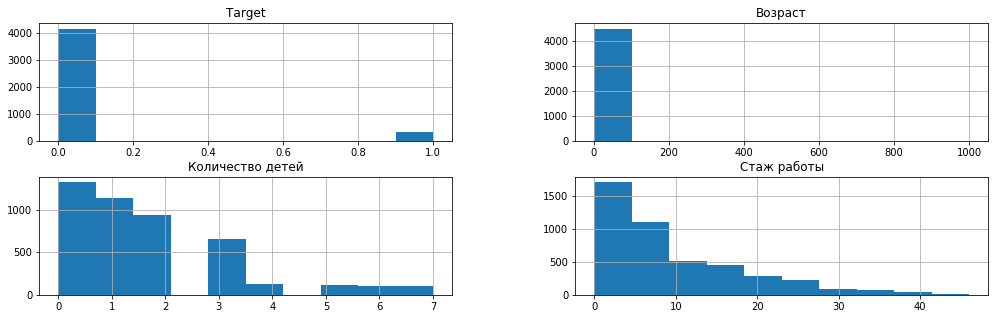

In [299]:
print('Гистограмы для обучающей выборки')
train_hist = train_df.hist()

Гистограмы для тестовой выборки


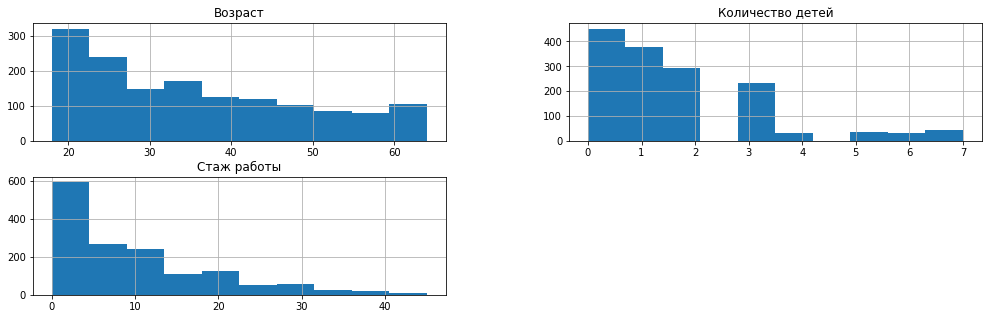

In [300]:
print('Гистограмы для тестовой выборки')
test_hist = test_df.hist()

In [301]:
print('---Образование: ')
print(train_df['Образование'].value_counts())
print('\n---Семейное положение:')
print(train_df['Семейное положение'].value_counts())
print('\n---Пол:')
print(train_df['Пол'].value_counts())
print('\n---Дефолт:')
print(train_df['Target'].value_counts())
display(train_df.describe())

---Образование: 
высшее                2096
средне-специальное    1450
среднее                714
несколько высших       240
Name: Образование, dtype: int64

---Семейное положение:
не женат / не замужем    1801
разведен / разведена     1380
повторный брак            864
женат / замужем           441
Name: Семейное положение, dtype: int64

---Пол:
мужской    2697
женский    1790
Name: Пол, dtype: int64

---Дефолт:
0    4144
1     356
Name: Target, dtype: int64


,Возраст,Стаж работы,Количество детей,Target
count,4500.000000,4500.000000,4500.000000,4500.000000
mean,35.459111,9.457333,1.647556,0.079111
std,19.763333,9.038025,1.651784,0.269942
min,1.000000,0.000000,0.000000,0.000000
25%,23.000000,2.000000,0.000000,0.000000
50%,32.000000,7.000000,1.000000,0.000000
75%,45.000000,14.000000,2.000000,0.000000
max,1000.000000,46.000000,7.000000,1.000000


In [302]:
print('---Образование: ')
print(test_df['Образование'].value_counts())
print('\n---Семейное положение:')
print(test_df['Семейное положение'].value_counts())
print('\n---Пол:')
print(test_df['Пол'].value_counts())
display(test_df.describe())

---Образование: 
высшее                683
средне-специальное    520
среднее               213
несколько высших       84
Name: Образование, dtype: int64

---Семейное положение:
не женат / не замужем    618
разведен / разведена     428
повторный брак           302
женат / замужем          152
Name: Семейное положение, dtype: int64

---Пол:
мужской    895
женский    605
Name: Пол, dtype: int64


,Возраст,Стаж работы,Количество детей
count,1500.000000,1500.000000,1500.000000
mean,35.520000,9.538000,1.660000
std,13.659502,9.421734,1.709488
min,18.000000,0.000000,0.000000
25%,23.000000,2.000000,0.000000
50%,33.000000,7.000000,1.000000
75%,45.500000,14.000000,3.000000
max,64.000000,45.000000,7.000000


Что можно уже отметить из данных результатов:

- Гистограма поля <b>Target</b> говорит о том, что искомые классы несбалансированы (отношение тех, кто ушел в дефолт, к тем, кто выплатил кредит меньше 10%) , что важно учитывать при классификации. 
- В графе <b>Возраст</b> максимумом является '1000 лет', что говорит о наличии аномалий. В тестовой выборке таких выбросов нет. Минимальный возраст в '1 год' тоже вызывает сомнения,  с учетом требований на выдачу кредита.
- Есть несколько <b>Null</b> значений в графе <b>Пол</b>

In [303]:
display(train_df[train_df['Возраст']>64])
display(train_df[train_df['Возраст']<18])

,Пол,Возраст,Образование,Стаж работы,Семейное положение,Количество детей,Target
3,мужской,1000,средне-специальное,2,не женат / не замужем,1,0
327,мужской,100,высшее,9,женат / замужем,3,0
877,мужской,98,средне-специальное,1,не женат / не замужем,2,0
1677,мужской,79,средне-специальное,34,не женат / не замужем,1,0
2377,мужской,89,средне-специальное,4,женат / замужем,0,0
3202,мужской,124,средне-специальное,18,повторный брак,3,0
3802,мужской,99,высшее,5,не женат / не замужем,3,0


,Пол,Возраст,Образование,Стаж работы,Семейное положение,Количество детей,Target
0,мужской,1,средне-специальное,26,разведен / разведена,0,0
200,женский,6,высшее,1,разведен / разведена,2,0
950,мужской,17,средне-специальное,9,разведен / разведена,3,0
1600,мужской,15,средне-специальное,3,разведен / разведена,1,0
2375,мужской,6,высшее,12,разведен / разведена,0,0
3250,мужской,8,высшее,1,не женат / не замужем,2,0


Вышеуказанные записи относятся к большему классу (тех кто не ушел в дефолт), и подобных аномалий в тестовой выборке - нет. В связи с этим сочтем эти аномалии за аутлаеры и выкинем их из обучающей выборки

In [304]:
train_df = train_df[(train_df['Возраст']<65)&((train_df['Возраст']>17))]

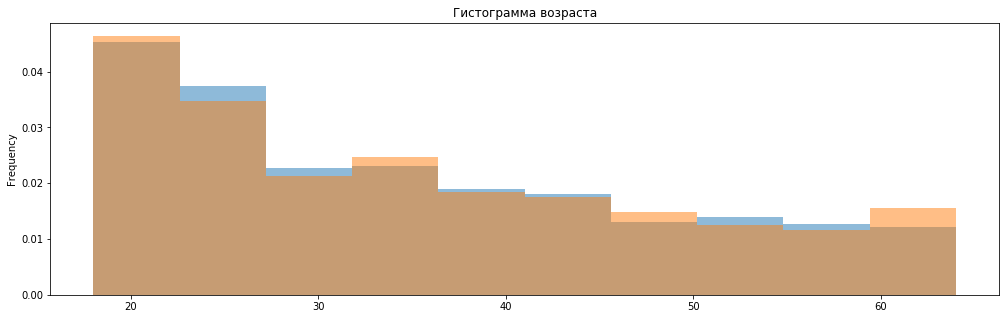

In [305]:
train_df['Возраст'].plot.hist(title = 'Гистограмма возраста',alpha =0.5, density=1);
test_df['Возраст'].plot.hist(title = 'Гистограмма возраста',alpha =0.5, density=1);

Избавимся от строк содержащих <b>Null</b>. Все эти записи имеют метку большего класса, их  потеря не несет существенного вреда (однако некоторые модели способны работать с неполными данными, но в данной ситуации строк с <b>Null</b> немного, и можно их отбросить)

In [306]:
train_df.dropna(inplace=True)

In [307]:
train_df.index = np.arange(len(train_df))

Для работы с категориальными признаками воспользуемся <b>OHE (One hot encoding)</b>. Так как <b>Пол</b> - признак бинарный, для можно просто перекодировать признак: 1 - "мужской", 0 - "женский".

In [308]:
train_df['Пол'] = (train_df['Пол'] == 'мужской').astype('int')
train_df = train_df.rename(columns={'Пол': 'Пол_мужской'})

test_df['Пол'] = (test_df['Пол'] == 'мужской').astype('int')
test_df = test_df.rename(columns={'Пол': 'Пол_мужской'})

train_df = pd.get_dummies(train_df)
test_df = pd.get_dummies(test_df)
train_df.sample(5)

,Пол_мужской,Возраст,Стаж работы,Количество детей,Target,Образование_высшее,Образование_несколько высших,Образование_средне-специальное,Образование_среднее,Семейное положение_женат / замужем,Семейное положение_не женат / не замужем,Семейное положение_повторный брак,Семейное положение_разведен / разведена
1986,1,21,3,1,0,1,0,0,0,0,1,0,0
509,1,23,5,3,1,0,0,1,0,0,0,1,0
174,0,47,9,3,0,0,0,0,1,1,0,0,0
2317,1,19,0,3,0,0,0,0,1,0,1,0,0
3541,1,32,14,0,0,1,0,0,0,0,1,0,0


In [310]:
train_df.corr()

,Пол_мужской,Возраст,Стаж работы,Количество детей,Target,Образование_высшее,Образование_несколько высших,Образование_средне-специальное,Образование_среднее,Семейное положение_женат / замужем,Семейное положение_не женат / не замужем,Семейное положение_повторный брак,Семейное положение_разведен / разведена
Пол_мужской,1.000000,-0.012861,-0.002047,0.016461,0.078541,0.002323,0.003889,0.004157,-0.010858,-0.001848,-0.010453,0.012505,0.001601
Возраст,-0.012861,1.000000,0.551535,-0.043038,-0.088897,0.002218,-0.015627,-0.002809,0.010143,0.000148,0.024229,-0.012764,-0.014920
Стаж работы,-0.002047,0.551535,1.000000,-0.023439,-0.081678,-0.019604,0.008805,0.008987,0.009858,0.002490,0.019755,-0.004530,-0.018723
Количество детей,0.016461,-0.043038,-0.023439,1.000000,-0.012815,-0.019534,-0.002415,0.022413,-0.000497,-0.008761,-0.029066,0.016329,0.022570
Target,0.078541,-0.088897,-0.081678,-0.012815,1.000000,-0.020308,-0.031961,-0.002738,0.050781,-0.026451,0.034920,-0.051897,0.024379
Образование_высшее,0.002323,0.002218,-0.019604,-0.019534,-0.020308,1.000000,-0.221366,-0.643262,-0.406594,-0.034154,0.008806,-0.004953,0.016936
Образование_несколько высших,0.003889,-0.015627,0.008805,-0.002415,-0.031961,-0.221366,1.000000,-0.163081,-0.103081,-0.017878,0.003836,0.015822,-0.006068
Образование_средне-специальное,0.004157,-0.002809,0.008987,0.022413,-0.002738,-0.643262,-0.163081,1.000000,-0.299539,0.038435,0.003399,-0.004662,-0.024443
Образование_среднее,-0.010858,0.010143,0.009858,-0.000497,0.050781,-0.406594,-0.103081,-0.299539,1.000000,0.008464,-0.018698,0.003005,0.011831
Семейное положение_женат / замужем,-0.001848,0.000148,0.002490,-0.008761,-0.026451,-0.034154,-0.017878,0.038435,0.008464,1.000000,-0.270543,-0.161613,-0.220012


In [311]:
train_df[train_df['Target']==0].describe()

,Пол_мужской,Возраст,Стаж работы,Количество детей,Target,Образование_высшее,Образование_несколько высших,Образование_средне-специальное,Образование_среднее,Семейное положение_женат / замужем,Семейное положение_не женат / не замужем,Семейное положение_повторный брак,Семейное положение_разведен / разведена
count,4110.000000,4110.000000,4110.000000,4110.000000,4110.0,4110.000000,4110.000000,4110.000000,4110.000000,4110.000000,4110.000000,4110.000000,4110.000000
mean,0.588321,35.549148,9.689538,1.655961,0.0,0.469100,0.055231,0.321898,0.153771,0.100730,0.396350,0.199027,0.303893
std,0.492197,13.386240,9.183453,1.649615,0.0,0.499105,0.228459,0.467261,0.360773,0.301007,0.489198,0.399317,0.459993
min,0.000000,18.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,24.000000,2.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,33.000000,7.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,45.000000,15.000000,2.000000,0.0,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000
max,1.000000,64.000000,46.000000,7.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [312]:
train_df[train_df['Target']!=0].describe()

,Пол_мужской,Возраст,Стаж работы,Количество детей,Target,Образование_высшее,Образование_несколько высших,Образование_средне-специальное,Образование_среднее,Семейное положение_женат / замужем,Семейное положение_не женат / не замужем,Семейное положение_повторный брак,Семейное положение_разведен / разведена
count,350.000000,350.000000,350.000000,350.000000,350.0,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000
mean,0.731429,31.145714,6.942857,1.577143,1.0,0.431429,0.028571,0.317143,0.222857,0.071429,0.460000,0.122857,0.345714
std,0.443851,11.827263,6.722680,1.707406,0.0,0.495985,0.166837,0.466030,0.416759,0.257908,0.499111,0.328743,0.476281
min,0.000000,18.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,22.000000,2.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,27.000000,5.000000,1.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,38.000000,10.000000,3.000000,1.0,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000
max,1.000000,64.000000,29.000000,7.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [313]:
correlations = train_df.corr()['Target'].sort_values()
print(correlations[:-1])

Возраст                                    -0.088897
Стаж работы                                -0.081678
Семейное положение_повторный брак          -0.051897
Образование_несколько высших               -0.031961
Семейное положение_женат / замужем         -0.026451
Образование_высшее                         -0.020308
Количество детей                           -0.012815
Образование_средне-специальное             -0.002738
Семейное положение_разведен / разведена     0.024379
Семейное положение_не женат / не замужем    0.034920
Образование_среднее                         0.050781
Пол_мужской                                 0.078541
Name: Target, dtype: float64


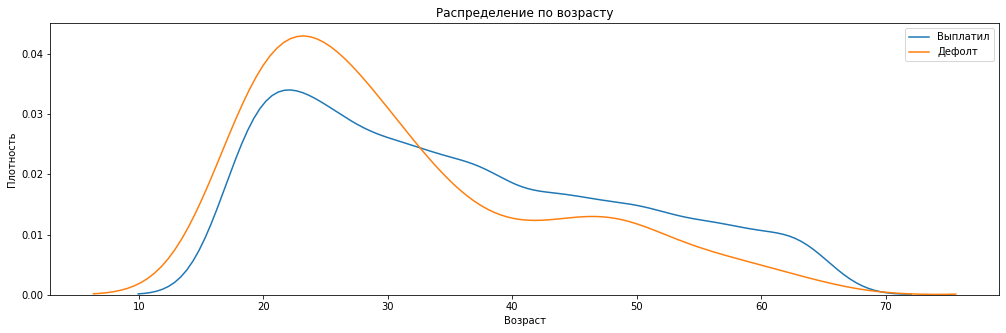

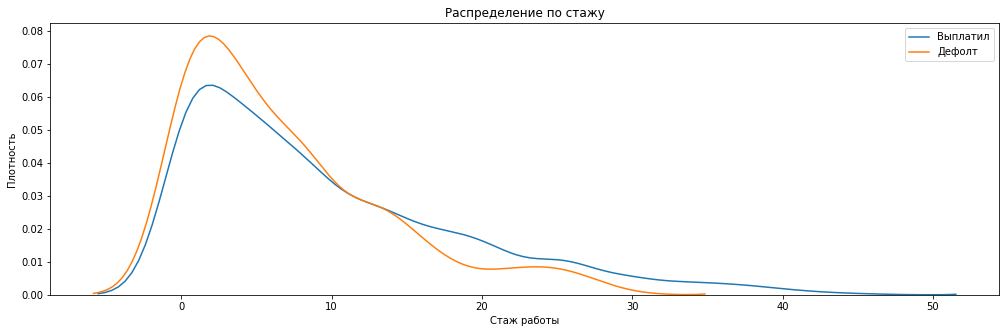

In [314]:
sns.kdeplot(train_df.loc[train_df['Target'] == 0, 'Возраст'], label = 'Выплатил')
sns.kdeplot(train_df.loc[train_df['Target'] == 1, 'Возраст'], label = 'Дефолт')
plt.xlabel('Возраст'); plt.ylabel('Плотность'); plt.title('Распределение по возрасту');
plt.show()

sns.kdeplot(train_df.loc[train_df['Target'] == 0, 'Стаж работы'], label = 'Выплатил')
sns.kdeplot(train_df.loc[train_df['Target'] == 1, 'Стаж работы'], label = 'Дефолт')
plt.xlabel('Стаж работы'); plt.ylabel('Плотность'); plt.title('Распределение по стажу');
plt.show()

<b>Что можно заметить?</b> Все корреляции очень слабые, и не могут явно выделить вероятность дефолта. Однако, явная корреляция возраста и стажа работы при оценке вероятности выплатить кредит - есть. Также - мужчины чаще не выплачивают кредит, чем женщины. 

## PCA
Попробуем уменьшить размерность данных и визуально оценить распределение классов с помощью PCA - метода главных компонент. 

In [260]:
train = train_df.drop(columns='Target')
train_labels = train_df['Target']
test = test_df

Количество информации о данных, объясняемое 1 главной компонентой: 0.80
Количество информации о данных, объясняемое 2 главной компонентой: 0.18


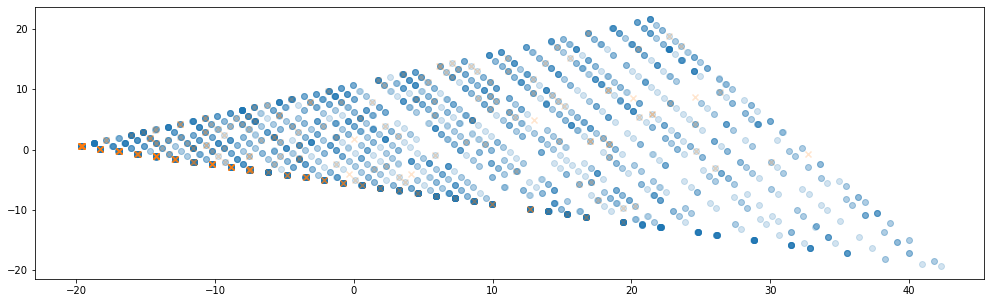

In [42]:
pca = PCA(n_components=2)
pca.fit(train)
print('Количество информации о данных, объясняемое 1 главной компонентой: %0.2f' % pca.explained_variance_ratio_[0])
print('Количество информации о данных, объясняемое 2 главной компонентой: %0.2f' % pca.explained_variance_ratio_[1])
train_pca = pca.transform(train)
plt.scatter(train_pca[:,0][train_labels==0], train_pca[:,1][train_labels==0] ,alpha=0.2)
plt.scatter(train_pca[:,0][train_labels==1], train_pca[:,1][train_labels==1] , marker='x' ,alpha=0.2)

Несмотря на то, что метод главных компонент позволяет получить вектор, описывающий достаточно большое кол-во информации (>98%), видно что после такого преобразования существуют данные, имеющие для одних и тех же предикторов разные метки: крестик - для тех, кто ушел в дефолт, круг - для тех кто выплатил. Яркость метки помогает понять как часто данные попадали в эту точку - в данном преобразовании ушедшие в дефолт сконцентрировались на нижней стороне "прямоугольника". Такая концентрация помогает визуально подтвердить, что распределение у обоих классов - разные (хотя понять их и не поомогает)

## Логистическая регрессия

Начнем с логистической регрессии. Рассмотрим различные способы для ее использования. Для проверки будут использоваться 25% данных для обучения. 

Первым делом нормализуем данные. Затем отделим от обучающей выборки валидационную с учетом пропорций классов.

In [162]:
features = list(train.columns)
scaler = MinMaxScaler(feature_range = (0, 1))

scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (4460, 12)
Testing data shape:  (1500, 12)


In [163]:
X_train, X_test, y_train, y_test = train_test_split(train, train_labels, random_state =41, stratify = train_labels)

Обучим модели с гиперпараметрами по умолчанию. Рассмотрим результаты на метрике <b>Accuracy</b> - вероятности правильно предсказать класс.

In [164]:
log_reg = LogisticRegression(C=0.1)
log_reg.fit(X_train, y_train)

valid_prob_pred = log_reg.predict_proba(X_test)[:,1]
train_prob_pred = log_reg.predict_proba(X_train)[:,1]
accuracy = []
for i in range(21):
    threshold = 0.05*i
    predict = np.array(valid_prob_pred > threshold)
    accuracy.append([threshold, accuracy_score(predict , y_test)])

for i in range(21):
    print('Threshhold = %0.3f' %accuracy[i][0]+ ', accuracy = %0.4f'%accuracy[i][1])

Threshhold = 0.000, accuracy = 0.0780
Threshhold = 0.050, accuracy = 0.2924
Threshhold = 0.100, accuracy = 0.7489
Threshhold = 0.150, accuracy = 0.9031
Threshhold = 0.200, accuracy = 0.9220
Threshhold = 0.250, accuracy = 0.9220
Threshhold = 0.300, accuracy = 0.9220
Threshhold = 0.350, accuracy = 0.9220
Threshhold = 0.400, accuracy = 0.9220
Threshhold = 0.450, accuracy = 0.9220
Threshhold = 0.500, accuracy = 0.9220
Threshhold = 0.550, accuracy = 0.9220
Threshhold = 0.600, accuracy = 0.9220
Threshhold = 0.650, accuracy = 0.9220
Threshhold = 0.700, accuracy = 0.9220
Threshhold = 0.750, accuracy = 0.9220
Threshhold = 0.800, accuracy = 0.9220
Threshhold = 0.850, accuracy = 0.9220
Threshhold = 0.900, accuracy = 0.9220
Threshhold = 0.950, accuracy = 0.9220
Threshhold = 1.000, accuracy = 0.9220


При <b>threshold = 0.0 </b> мы видим 0.087 верных ответов,  при <b>threshold = 0.2 </b> видим 1-0.087 = 0.913 правильных ответов, и это значение  с ростом threshold не меняется. Таким образом по метке <b>Accuracy</b> - наилучший результат достигается для константной модели, утверждающей, что все выплатят кредит.

В заданиях подобного рода уместнее использовать <b>ROC AUC</b> метрику, учитывающей значение <b>True positive rate (TPR)</b> и <b>False positive rate (FPR)</b>, вычисляемых по формуле:
 $$ TPR = \frac{TP}{TP + FN}, FPR = \frac{FP}{FP + TN} $$
<b>FPR</b> определяет долю ошибок допущенных моделью, <b>TPR</b> определяет долю выявленных моделью дефолтов. Производной от этих двух метрик и является <b>ROC AUC</b> - площадь под кривой, построенной по значениям <b>TPR</b> и <b>FPR</b>.

In [165]:
def Show_ROC(y_test, prob_pred,  label = '', plot=True):
    fpr, tpr, threshold = roc_curve(y_test, prob_pred)
    roc_auc = auc(fpr, tpr)

    if plot:
        plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.5f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])

        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC '+label)
        plt.legend(loc="lower right")
        plt.show()

        plt.plot(threshold[1:], tpr[1:], label = 'True Positive Rate')
        plt.plot(threshold[1:], fpr[1:], label = 'False Positive Rate')
        plt.ylabel('False Positive and True Positive Rate')
        plt.xlabel('threshold')
        plt.legend(loc="upper right")
        plt.show()   
    else: 
        print('ROC curve (area = %0.5f)' % roc_auc)

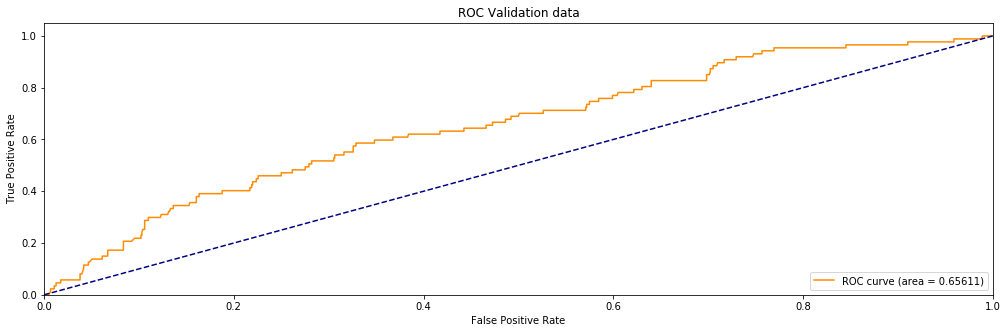

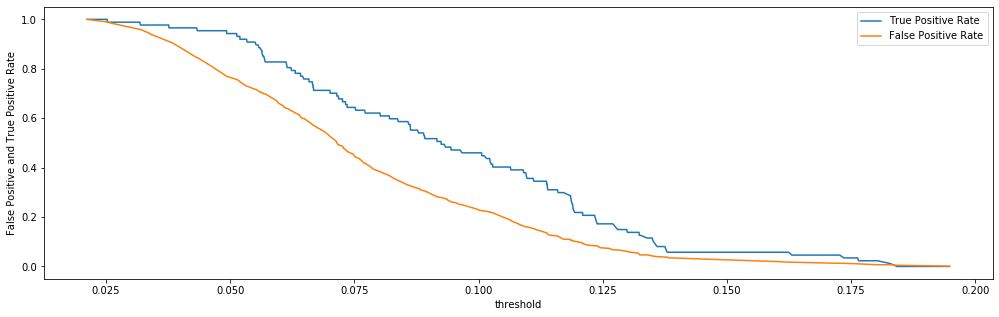

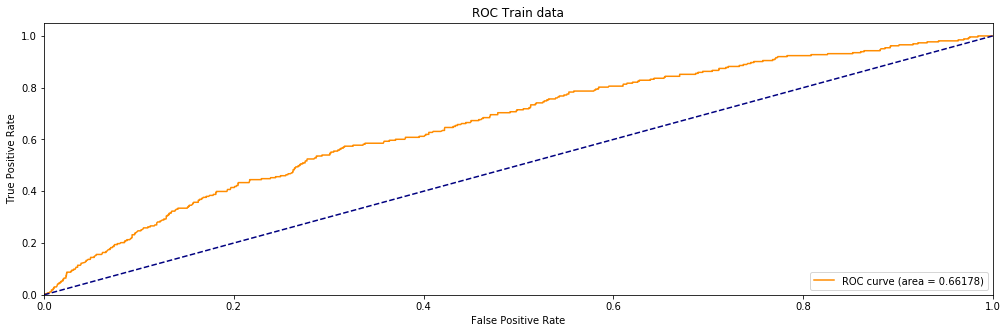

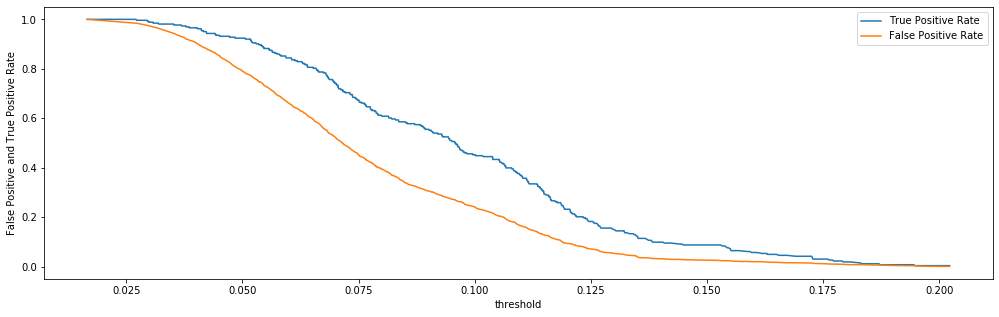

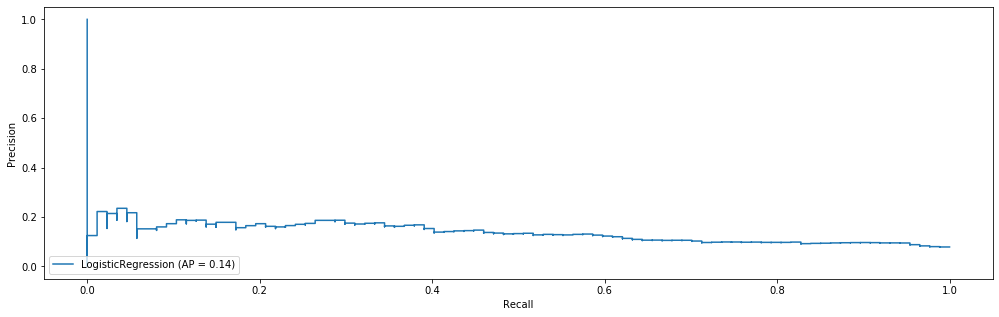

In [166]:
Show_ROC(y_test, valid_prob_pred, 'Validation data')
Show_ROC(y_train, train_prob_pred, 'Train data')
disp = plot_precision_recall_curve(log_reg, X_test, y_test)

Значение <b>ROC AUC</b> может изменяться от 0 до 1. Чем ближе к 1 или 0, тем лучше модель объясняет поведение данных. В нашем случае мы получили значение 0.67 (указано на первом графике). На втором графике можно увидеть нагляднее как изменяется точность. 

Для интереса можно рассмотреть также метрики <b>Precision</b>  (точность) и <b>Recall</b> (полнота)

Попробуем также использовать L1 регуляризацию и различный вес классов, для повышения точности.

In [167]:
log_reg = LogisticRegression(penalty='l1', C=0.1, solver='liblinear')
log_reg.fit(X_train, y_train)

valid_prob_pred = log_reg.predict_proba(X_test)[:,1]
train_prob_pred = log_reg.predict_proba(X_train)[:,1]

Show_ROC(y_test, valid_prob_pred, 'Validation data', False)
Show_ROC(y_train, train_prob_pred, 'Train data', False)

ROC curve (area = 0.65738)
ROC curve (area = 0.65090)


In [168]:
l1_coef = pd.DataFrame(log_reg.coef_.reshape(-1,1), index=features)
l1_coef

,0
Пол_мужской,0.365851
Возраст,-0.688778
Стаж работы,-0.062142
Количество детей,0.000000
Образование_высшее,0.000000
Образование_несколько высших,0.000000
Образование_средне-специальное,0.000000
Образование_среднее,0.249475
Семейное положение_женат / замужем,0.000000
Семейное положение_не женат / не замужем,0.009500


In [169]:
log_reg = LogisticRegression(penalty='l1', C=0.1, class_weight='balanced',solver='liblinear')
log_reg.fit(X_train, y_train)

valid_prob_pred = log_reg.predict_proba(X_test)[:,1]
train_prob_pred = log_reg.predict_proba(X_train)[:,1]

Show_ROC(y_test, valid_prob_pred, 'Validation data', False)
Show_ROC(y_train, train_prob_pred, 'Train data', False)

ROC curve (area = 0.66135)
ROC curve (area = 0.66163)


In [158]:
l1_coef = pd.DataFrame(log_reg.coef_.reshape(-1,1), index=features)
l1_coef

,0
Пол_мужской,0.479932
Возраст,-0.703717
Стаж работы,-1.143025
Количество детей,-0.196473
Образование_высшее,0.000000
Образование_несколько высших,-0.429391
Образование_средне-специальное,0.000000
Образование_среднее,0.314616
Семейное положение_женат / замужем,-0.062968
Семейное положение_не женат / не замужем,0.237031


In [170]:
log_reg = LogisticRegression(penalty='l2', C=0.1, class_weight='balanced')
log_reg.fit(X_train, y_train)

valid_prob_pred = log_reg.predict_proba(X_test)[:,1]
train_prob_pred = log_reg.predict_proba(X_train)[:,1]

Show_ROC(y_test, valid_prob_pred, 'Validation data', False)
Show_ROC(y_train, train_prob_pred, 'Train data', False)

ROC curve (area = 0.66611)
ROC curve (area = 0.66322)


## Выводы после использования логистической регрессии
Основная идея логистической регрессии заключается в том, что пространство исходных значений может быть разделено линейной границей. После PCA было видно, что в двумерной проекции данных эффективного способа разделить данные линией не было. Таким образом использование линейной классификации эффективного разделения не показало

Это видно на примере различных регуляризаций (L1, L2) - повышение доли выявления дефолтных случае влечет увеличение доли ошибок. Использование L1 регуляризации определило признаки <b>повторного брака, среднего образования, стажа работы, возраста</b> и <b>мужского пола </b> как наиболее важными при прогнозе дефолта (такова черта L1 регуляризаций) без учета баланса классов. 

При этом с введением баланса классов при обучении, обнуления признаков просиходит только у  <b>наличия одного высшего </b> и <b>наличия только средне-специального образования</b>. 

## Добавление признаков

Построению нелинейных разделяющих поверхностей может помочь использование полиномиальных признаков. Расмотрим корреляции подобных агрегированных признаков с полем <b>Target</b>.

In [111]:
poly = PolynomialFeatures(degree=3)
poly.fit(train_df.drop(columns='Target'))
train_poly = poly.transform(train_df.drop(columns='Target'))

In [114]:
train_poly_df = pd.DataFrame(train_poly, 
                             columns = poly.get_feature_names())

train_poly_df['Target'] = train_labels

poly_corrs = train_poly_df.corr()['Target'].sort_values()

print(poly_corrs.head(10))

x1 x3      -0.040265
x1^2 x3    -0.037921
x3         -0.033883
x2 x3      -0.032914
x1 x2 x3   -0.030874
x3 x4 x8   -0.029007
x2 x8^2    -0.028829
x2 x8      -0.028829
x2 x3 x8   -0.027718
x1 x3^2    -0.026980
Name: Target, dtype: float64


In [192]:
X_train, X_test, y_train, y_test = train_test_split(train_poly, train_labels, random_state =41)

In [178]:
log_reg = LogisticRegression(penalty='l1', class_weight='balanced', C=0.1, solver='liblinear')
log_reg.fit(X_train, y_train)

valid_prob_pred = log_reg.predict_proba(X_test)[:,1]
train_prob_pred = log_reg.predict_proba(X_train)[:,1]

Show_ROC(y_test, valid_prob_pred, 'Validation data', False)
Show_ROC(y_train, train_prob_pred, 'Train data', False)

ROC curve (area = 0.62527)
ROC curve (area = 0.73484)


Увеличение количества признаков часто ведет к переобучению, поэтому стоит уделить внимание способу и параметрам регуляризации. Попробуем подобрать наилучшие параметры.

In [180]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

c_values = np.logspace(-2, 3, 100)

logit_searcher_l2 = LogisticRegressionCV(Cs=c_values,penalty='l2', cv=skf, class_weight='balanced', n_jobs=-1)
logit_searcher_l2.fit(X_train, y_train)

C:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegressionCV(Cs=array([1.00000000e-02, 1.12332403e-02, 1.26185688e-02, 1.41747416e-02,
       1.59228279e-02, 1.78864953e-02, 2.00923300e-02, 2.25701972e-02,
       2.53536449e-02, 2.84803587e-02, 3.19926714e-02, 3.59381366e-02,
       4.03701726e-02, 4.53487851e-02, 5.09413801e-02, 5.72236766e-02,
       6.42807312e-02, 7.22080902e-02, 8.11130831e-02, 9.11162756e-02,
       1.02353102e-01, 1.14...
       1.09749877e+02, 1.23284674e+02, 1.38488637e+02, 1.55567614e+02,
       1.74752840e+02, 1.96304065e+02, 2.20513074e+02, 2.47707636e+02,
       2.78255940e+02, 3.12571585e+02, 3.51119173e+02, 3.94420606e+02,
       4.43062146e+02, 4.97702356e+02, 5.59081018e+02, 6.28029144e+02,
       7.05480231e+02, 7.92482898e+02, 8.90215085e+02, 1.00000000e+03]),
                     class_weight='balanced',
                     cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
                     n_jobs=-1)

In [193]:
valid_prob_pred = logit_searcher_l2.predict_proba(X_test)[:,1]
train_prob_pred = logit_searcher_l2.predict_proba(X_train)[:,1]

Show_ROC(y_test, valid_prob_pred, 'Validation data', False)
Show_ROC(y_train, train_prob_pred, 'Train data', False)

ROC curve (area = 0.64322)
ROC curve (area = 0.69892)


In [186]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

c_values = np.logspace(-2, 3, 100)

logit_searcher_l1 = LogisticRegressionCV(Cs=c_values,penalty='l1', cv=skf, class_weight='balanced', solver='liblinear', verbose=1, n_jobs=-1)
logit_searcher_l1.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 19.8min finished
C:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegressionCV(Cs=array([1.00000000e-02, 1.12332403e-02, 1.26185688e-02, 1.41747416e-02,
       1.59228279e-02, 1.78864953e-02, 2.00923300e-02, 2.25701972e-02,
       2.53536449e-02, 2.84803587e-02, 3.19926714e-02, 3.59381366e-02,
       4.03701726e-02, 4.53487851e-02, 5.09413801e-02, 5.72236766e-02,
       6.42807312e-02, 7.22080902e-02, 8.11130831e-02, 9.11162756e-02,
       1.02353102e-01, 1.14...
       1.74752840e+02, 1.96304065e+02, 2.20513074e+02, 2.47707636e+02,
       2.78255940e+02, 3.12571585e+02, 3.51119173e+02, 3.94420606e+02,
       4.43062146e+02, 4.97702356e+02, 5.59081018e+02, 6.28029144e+02,
       7.05480231e+02, 7.92482898e+02, 8.90215085e+02, 1.00000000e+03]),
                     class_weight='balanced',
                     cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
                     n_jobs=-1, penalty='l1', solver='liblinear', verbose=1)

In [194]:
valid_prob_pred = logit_searcher_l1.predict_proba(X_test)[:,1]
train_prob_pred = logit_searcher_l1.predict_proba(X_train)[:,1]

Show_ROC(y_test, valid_prob_pred, 'Validation data', False)
Show_ROC(y_train, train_prob_pred, 'Train data', False)

ROC curve (area = 0.58701)
ROC curve (area = 0.76775)


Все корреляции очень слабые и точность модели на валидации не выросла. Изменения в точности на обучающей выборке - следствие увеличение параметров и не говорит о повышении эффективности.

In [396]:
log_reg = LogisticRegression(penalty='l2', C=0.1, class_weight='balanced')
log_reg.fit(train, train_labels)

LogReg_result = pd.DataFrame(log_reg.predict_proba(test)[:,1])

LogReg_result.columns = ['Target']
LogReg_result.to_excel('Logistic.xlsx')

Попробуем провести классификацию с помощью еще нескольких моделей - <b>нелинейных SVM</b>, <b>случайного леса</b> и <b>градиентного бустинга</b>. 

## SVM

In [338]:
X_train, X_test, y_train, y_test = train_test_split(train, train_labels, random_state =41, stratify = train_labels)

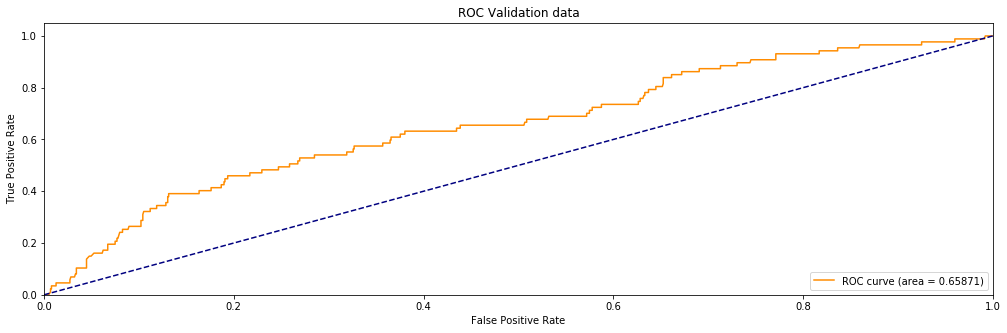

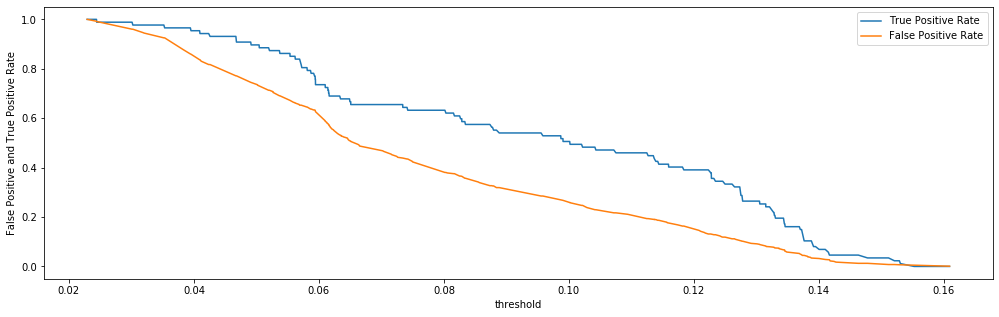

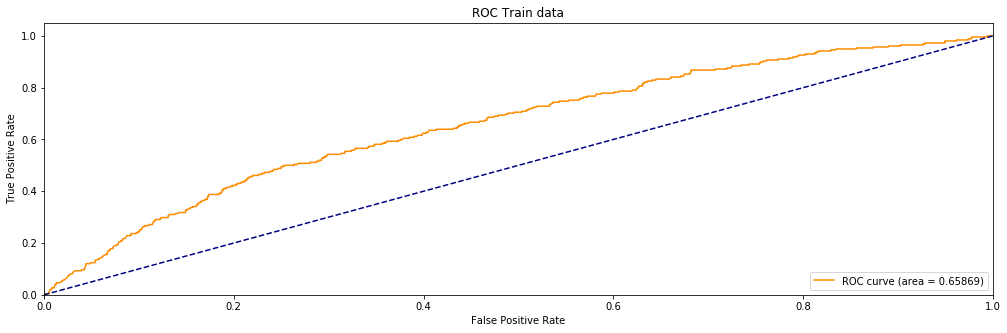

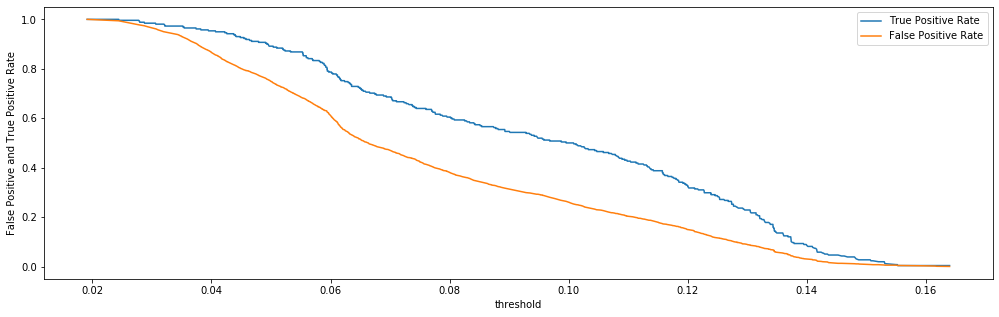

In [379]:
SVM = svm.SVC(kernel='rbf', C =0.1, gamma='auto', class_weight='balanced', probability=True)
SVM.fit(X_train, y_train)
Show_ROC(y_test, SVM.predict_proba(X_test)[:, 1], "Validation data")
Show_ROC(y_train, SVM.predict_proba(X_train)[:, 1], "Train data")

In [384]:
SVM = svm.SVC(kernel='rbf', C =0.1, gamma='auto', class_weight='balanced', probability=True)
SVM.fit(train, train_labels)


SVC(C=0.1, class_weight='balanced', gamma='auto', probability=True)

In [391]:
svm_result = pd.DataFrame(SVM.predict_proba(test)[:, 1].reshape(-1,1))
svm_result.columns = ['Target']
svm_result.to_excel('svm.xlsx')

## Random forest

In [357]:
random_forest = RandomForestClassifier(n_estimators = 10,  random_state = 41,max_depth=4,
                                       verbose = 1, n_jobs = -1)

random_forest.fit(X_train, y_train)
train_prob_pred = random_forest.predict_proba(X_train)[:, 1]
valid_prob_pred = random_forest.predict_proba(X_test)[:, 1]

Show_ROC(y_test, valid_prob_pred, 'Validation data', False)
Show_ROC(y_train, train_prob_pred, 'Train data', False)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


ROC curve (area = 0.64294)
ROC curve (area = 0.71667)


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


In [373]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

prob_pred = np.zeros(test.shape[0])
out_of_fold = np.zeros(train.shape[0])

valid_scores = []
train_scores = []


for train_indices, valid_indices in skf.split(train, train_labels):
    X_train, y_train = train[train_indices], train_labels[train_indices]
    X_valid, y_valid = train[valid_indices], train_labels[valid_indices]

    random_forest = RandomForestClassifier(n_estimators = 15,  random_state = 41,
                                           max_depth=4, verbose = 1, n_jobs = -1)
    random_forest.fit(X_train, y_train)
    
    model.fit(X_train, y_train, eval_metric = 'auc',
                  eval_set = [(X_valid, y_valid ), (X_train, y_train)],
                  eval_names = ['valid', 'train'],
                  early_stopping_rounds = 200, verbose = 200)
    
    best_iteration = model.best_iteration_
    
    prob_pred += model.predict_proba(test, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
    
    out_of_fold[valid_indices] = model.predict_proba(X_valid, num_iteration = best_iteration)[:, 1]
    
    valid_score = model.best_score_['valid']['auc']
    train_score = model.best_score_['train']['auc']
        
    valid_scores.append(valid_score)
    train_scores.append(train_score)
    

rf_result = pd.DataFrame({'Target': prob_pred})

print(roc_auc_score(train_labels, out_of_fold))
print(np.mean(train_scores))

Training until validation scores don't improve for 200 rounds


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.0s finished


[200]	train's auc: 0.960978	train's binary_logloss: 0.335399	valid's auc: 0.623418	valid's binary_logloss: 0.48099
Early stopping, best iteration is:
[5]	train's auc: 0.768364	train's binary_logloss: 0.654575	valid's auc: 0.67394	valid's binary_logloss: 0.65919
Training until validation scores don't improve for 200 rounds


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.0s finished


[200]	train's auc: 0.958129	train's binary_logloss: 0.337392	valid's auc: 0.630527	valid's binary_logloss: 0.481249
Early stopping, best iteration is:
[4]	train's auc: 0.75222	train's binary_logloss: 0.661146	valid's auc: 0.656448	valid's binary_logloss: 0.663719
Training until validation scores don't improve for 200 rounds


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.0s finished


[200]	train's auc: 0.959333	train's binary_logloss: 0.328823	valid's auc: 0.586218	valid's binary_logloss: 0.515404
Early stopping, best iteration is:
[1]	train's auc: 0.750497	train's binary_logloss: 0.682729	valid's auc: 0.607977	valid's binary_logloss: 0.685025
Training until validation scores don't improve for 200 rounds


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.0s finished


[200]	train's auc: 0.958748	train's binary_logloss: 0.333158	valid's auc: 0.576121	valid's binary_logloss: 0.518434
Early stopping, best iteration is:
[8]	train's auc: 0.782743	train's binary_logloss: 0.634662	valid's auc: 0.616354	valid's binary_logloss: 0.652098
Training until validation scores don't improve for 200 rounds


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.0s finished


[200]	train's auc: 0.956927	train's binary_logloss: 0.336375	valid's auc: 0.571455	valid's binary_logloss: 0.486615
Early stopping, best iteration is:
[109]	train's auc: 0.921965	train's binary_logloss: 0.415079	valid's auc: 0.580492	valid's binary_logloss: 0.520891
0.6064734098018769
0.7951577163712138


In [375]:
rf_result.to_excel('rf.xlsx')

## LGBM

In [376]:
train = train_df.drop(columns='Target')
train_labels = train_df['Target']
test = test_df

n_folds = 4
k_fold = KFold(n_splits = n_folds,shuffle = True, random_state = 50)

feature_names = list(train.columns)

scaler = MinMaxScaler(feature_range = (0, 1))
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

feature_importance_values = np.zeros(len(feature_names))

out_of_fold = np.zeros(train.shape[0])
prob_pred = np.zeros(test.shape[0])

Training until validation scores don't improve for 200 rounds
[200]	train's auc: 0.958664	train's binary_logloss: 0.335414	valid's auc: 0.605202	valid's binary_logloss: 0.454917
Early stopping, best iteration is:
[39]	train's auc: 0.860981	train's binary_logloss: 0.520642	valid's auc: 0.62245	valid's binary_logloss: 0.558255
Training until validation scores don't improve for 200 rounds
[200]	train's auc: 0.965833	train's binary_logloss: 0.311255	valid's auc: 0.612714	valid's binary_logloss: 0.510483
Early stopping, best iteration is:
[15]	train's auc: 0.82426	train's binary_logloss: 0.589243	valid's auc: 0.630739	valid's binary_logloss: 0.617598
Training until validation scores don't improve for 200 rounds
[200]	train's auc: 0.955573	train's binary_logloss: 0.348773	valid's auc: 0.625158	valid's binary_logloss: 0.495419
Early stopping, best iteration is:
[9]	train's auc: 0.780809	train's binary_logloss: 0.629792	valid's auc: 0.650502	valid's binary_logloss: 0.647082
Training until vali

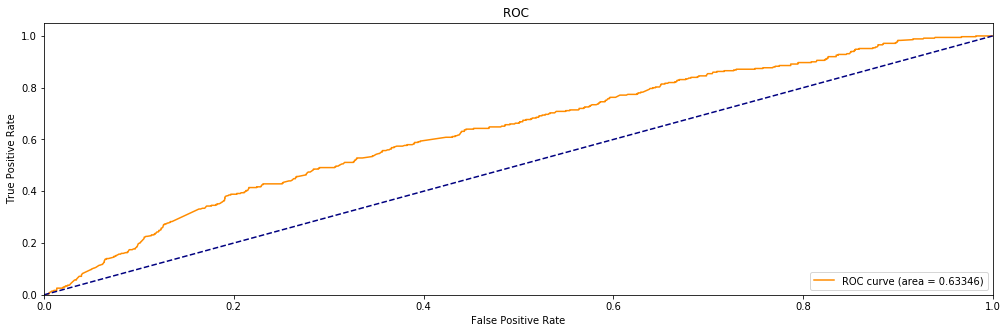

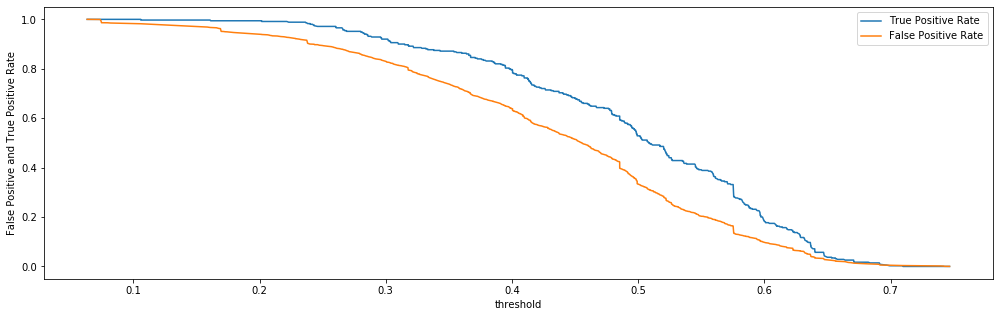

In [377]:
valid_scores = []
train_scores = []

for train_indices, valid_indices in k_fold.split(train):
    X_train, y_train = train[train_indices], train_labels[train_indices]
    X_valid, y_valid = train[valid_indices], train_labels[valid_indices]

    model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 41)
    
    model.fit(X_train, y_train, eval_metric = 'auc',
                  eval_set = [(X_valid, y_valid ), (X_train, y_train)],
                  eval_names = ['valid', 'train'],
                  early_stopping_rounds = 200, verbose = 200)
    
    best_iteration = model.best_iteration_
    
    feature_importance_values += model.feature_importances_ / k_fold.n_splits
    
    prob_pred += model.predict_proba(test, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
    
    out_of_fold[valid_indices] = model.predict_proba(X_valid, num_iteration = best_iteration)[:, 1]
    
    valid_score = model.best_score_['valid']['auc']
    train_score = model.best_score_['train']['auc']
        
    valid_scores.append(valid_score)
    train_scores.append(train_score)
    
lgbm_result = pd.DataFrame({'Target': prob_pred})
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})

valid_auc = roc_auc_score(train_labels, out_of_fold)
Show_ROC(train_labels, out_of_fold)

valid_scores.append(valid_auc)
train_scores.append(np.mean(train_scores))

fold_names = list(range(n_folds))
fold_names.append('overall')
    
metrics = pd.DataFrame({'fold': fold_names,
                        'train': train_scores,
                        'valid': valid_scores}) 

In [333]:
fi

,feature,importance
0,Пол_мужской,34.75
1,Возраст,159.50
2,Стаж работы,180.75
3,Количество детей,95.75
4,Образование_высшее,12.25
5,Образование_несколько высших,25.50
6,Образование_средне-специальное,11.75
7,Образование_среднее,28.50
8,Семейное положение_женат / замужем,19.00
9,Семейное положение_не женат / не замужем,18.00


In [335]:
metrics

,fold,train,valid
0,0,0.860981,0.622450
1,1,0.824260,0.630739
2,2,0.780809,0.650502
3,3,0.815648,0.652625
4,overall,0.820425,0.633455


In [378]:
lgbm_result.to_excel('LGBM.xlsx')

## Выводы

Качественной модели, способной выделить вероятность дефолта по представленным данным - найдено не было. Модели (за исключением логистической регрессии на полиномиальных признаках с балансировкой классов) показали близкие друг другу результаты по метрике <b>AUC</b>, хотя поведение <b>TPR</b> и <b>FPR</b> имело отличия - где-то чуть лучше выделяется дефолт с большими количествами ложных выявлений, где-то наоборот. Однако значительных скачков в данных метриков найдено не было. 

Для всех 4 используемых методов классификации получены значения для тестовой выборки, представленные в отдельных файлах.